Notebook to evaluate multihead unet

In [15]:
import os
from pprint import pprint
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

sys.path.append("../")

from monkey.config import TrainingIOConfig
from monkey.data.dataset import get_detection_dataloaders
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from monkey.model.hovernext.model import get_custom_hovernext
from monkey.model.utils import get_activation_function
from tqdm.autonotebook import tqdm
from monkey.model.utils import (
    get_multiclass_patch_F1_score_batch,
    get_patch_F1_score_batch,
)
from monkey.data.data_utils import imagenet_denormalise, dilate_mask
from monkey.model.hovernext.model import (
    get_convnext_unet,
    get_custom_hovernext,
)

run_config = {
    "val_fold": 5,  # [1-5]
    "batch_size": 8,
    "optimizer": "AdamW",
    "learning_rate": 0.0004,
    "weight_decay": 0.01,
    "epochs": 50,
    "loss_function": {
        "head_1": "BCE_Dice",
        "head_2": "BCE_Dice",
        "head_3": "BCE_Dice",
    },
    "loss_pos_weight": 1.0,
    "do_augmentation": True,
    "activation_function": {
        "head_1": "relu",
        "head_2": "relu",
        "head_3": "relu",
    },
    "use_nuclick_masks": False,  # Whether to use NuClick segmentation masks,
    "include_background_channel": False,
}

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
)

# Create model
# model = get_multihead_efficientunet(
#     out_channels=[1,1,1], pretrained=False
# )
# model = get_custom_hovernext(
#     enc="convnextv2_tiny.fcmae_ft_in22k_in1k",
#     pretrained=False,
#     use_batchnorm=True,
#     attention_type="scse",
# )

models = []
folds = [1, 2, 4]
for i in folds:
    checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/cell_multiclass_det/hovernext_det_large/fold_{i}/epoch_50.pth"
    # model = get_multihead_efficientunet(
    #     out_channels=[1,1,1], pretrained=False
    # )
    model = get_custom_hovernext(
        enc="convnextv2_large.fcmae_ft_in22k_in1k",
        pretrained=False,
        # use_batchnorm=True,
        # attention_type="scse",
    )
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    model.eval()
    model.to("cuda")
    models.append(model)

# checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/cell_multiclass_det/multihead_unet_512/fold_{run_config['val_fold']}/epoch_30.pth"
# checkpoint = torch.load(checkpoint_path)
# print(checkpoint["epoch"])
# model.load_state_dict(checkpoint["model"])
# model.eval()
# model.to("cuda")


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=run_config["batch_size"],
    do_augmentation=run_config["do_augmentation"],
    use_nuclick_masks=run_config["use_nuclick_masks"],
    disk_radius=11,
)


activation_dict = {
    "head_1": get_activation_function(
        run_config["activation_function"]["head_1"]
    ),
    "head_2": get_activation_function(
        run_config["activation_function"]["head_2"]
    ),
    "head_3": get_activation_function(
        run_config["activation_function"]["head_3"]
    ),
}

negative pixels: 738099225
lymph pixels: 5901049
mono pixels: 3372270
train patches: 11404
test patches: 2911


In [ ]:
def multihead_unet_post_process(
    logits_pred: torch.Tensor,
    activation_dict: dict[str, torch.nn.Module],
    thresholds: list = [0.3, 0.3, 0.3, 0.5],
) -> dict[str, np.ndarray]:
    """
    Args:
        Thresholds: [overall, lymph, mono, contour]
    """
    head_1_logits = logits_pred["head_1"]
    head_2_logits = logits_pred["head_2"]
    head_3_logits = logits_pred["head_3"]
    pred_probs_1 = activation_dict["head_1"](head_1_logits)
    pred_probs_2 = activation_dict["head_2"](head_2_logits)
    pred_probs_3 = activation_dict["head_3"](head_3_logits)

    contour_pred_binary = (
        (pred_probs_1[:, 1:2, :, :] > thresholds[3])
        .float()
        .numpy(force=True)
    )

    overall_pred_binary = (
        (pred_probs_1[:, 0:1, :, :] > thresholds[0])
        .float()
        .numpy(force=True)
    )
    lymph_pred_binary = (
        (pred_probs_2 > thresholds[1]).float().numpy(force=True)
    )
    mono_pred_binary = (
        (pred_probs_3 > thresholds[2]).float().numpy(force=True)
    )

    overall_pred_binary[contour_pred_binary == 1] = 0
    lymph_pred_binary[contour_pred_binary == 1] = 0
    mono_pred_binary[contour_pred_binary == 1] = 0

    processed_masks = {
        "inflamm_mask": overall_pred_binary[:, 0, :, :],
        "contour_mask": contour_pred_binary[:, 0, :, :],
        "lymph_mask": lymph_pred_binary[:, 0, :, :],
        "mono_mask": mono_pred_binary[:, 0, :, :],
        "inflamm_prob": pred_probs_1[:, 0, :, :].numpy(force=True),
        "contour_prob": pred_probs_1[:, 1, :, :].numpy(force=True),
        "lymph_prob": pred_probs_2[:, 0, :, :].numpy(force=True),
        "mono_prob": pred_probs_3[:, 0, :, :].numpy(force=True),
    }
    return processed_masks

In [5]:
def hovernext_det_post_process(
    inflamm_prob: torch.Tensor,
    lymph_prob: torch.Tensor,
    mono_prob: torch.Tensor,
    thresholds: list = [0.5, 0.5, 0.5],
    min_distances: list = [11, 9, 13],
):

    inflamm_prob = inflamm_prob.numpy(force=True)
    lymph_prob = lymph_prob.numpy(force=True)
    mono_prob = mono_prob.numpy(force=True)

    inflamm_prob = np.squeeze(inflamm_prob, axis=1)
    lymph_prob = np.squeeze(lymph_prob, axis=1)
    mono_prob = np.squeeze(mono_prob, axis=1)

    batches = inflamm_prob.shape[0]
    inflamm_output_mask = np.zeros(
        shape=(batches, inflamm_prob.shape[1], inflamm_prob.shape[2])
    )
    lymph_output_mask = np.zeros(
        shape=(batches, inflamm_prob.shape[1], inflamm_prob.shape[2])
    )
    mono_output_mask = np.zeros(
        shape=(batches, inflamm_prob.shape[1], inflamm_prob.shape[2])
    )

    for i in range(0, batches):
        inflamm_coordinates = peak_local_max(
            inflamm_prob[i],
            min_distance=min_distances[0],
            threshold_abs=thresholds[0],
            exclude_border=False,
        )
        inflamm_output_mask[i][
            inflamm_coordinates[:, 0], inflamm_coordinates[:, 1]
        ] = 1

        lymph_coordinates = peak_local_max(
            lymph_prob[i],
            min_distance=min_distances[1],
            threshold_abs=thresholds[1],
            exclude_border=False,
        )
        lymph_output_mask[i][
            lymph_coordinates[:, 0], lymph_coordinates[:, 1]
        ] = 1

        mono_coordinates = peak_local_max(
            mono_prob[i],
            min_distance=min_distances[2],
            threshold_abs=thresholds[2],
            exclude_border=False,
        )
        mono_output_mask[i][
            mono_coordinates[:, 0], mono_coordinates[:, 1]
        ] = 1

    return {
        "inflamm_mask": inflamm_output_mask,
        "lymph_mask": lymph_output_mask,
        "mono_mask": mono_output_mask,
    }

In [18]:
running_inflamm_f1 = 0.0
running_inflamm_precision = 0.0
running_inflamm_recall = 0.0
running_lymph_f1 = 0.0
running_lymph_precision = 0.0
running_lymph_recall = 0.0
running_mono_f1 = 0.0
running_mono_precision = 0.0
running_mono_recall = 0.0

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):
    images = data["image"].cuda().float()
    inflamm_true_masks = data["binary_mask"][:, 0, :, :].numpy(
        force=True
    )
    lymph_true_masks = data["class_mask"][:, 0, :, :].numpy(
        force=True
    )
    mono_true_masks = data["class_mask"][:, 1, :, :].numpy(force=True)

    with torch.no_grad():
        inflamm_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cuda"
        )
        lymph_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cuda"
        )
        mono_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cuda"
        )
        for model in models:
            logits_pred = model(images)
            head_1_logits = logits_pred[:, 0:1, :, :]
            head_2_logits = logits_pred[:, 1:2, :, :]
            head_3_logits = logits_pred[:, 2:3, :, :]

            _inflamm_prob = activation_dict["head_1"](head_1_logits)
            _lymph_prob = activation_dict["head_2"](head_2_logits)
            _mono_prob = activation_dict["head_3"](head_3_logits)

            inflamm_prob += _inflamm_prob
            lymph_prob += _lymph_prob
            mono_prob += _mono_prob

        inflamm_prob /= len(models)
        lymph_prob /= len(models)
        mono_prob /= len(models)

        processed_output = hovernext_det_post_process(
            inflamm_prob,
            lymph_prob,
            mono_prob,
            thresholds=[0.75, 0.75, 0.75],
            min_distances=[11, 11, 11],
        )

    # Compute detection F1 score
    inflamm_metrics = get_patch_F1_score_batch(
        processed_output["inflamm_mask"],
        inflamm_true_masks,
        5,
        inflamm_prob[:, 0, :, :],
    )
    lymph_metrics = get_patch_F1_score_batch(
        processed_output["lymph_mask"],
        lymph_true_masks,
        4,
        lymph_prob[:, 0, :, :],
    )
    mono_metrics = get_patch_F1_score_batch(
        processed_output["mono_mask"],
        mono_true_masks,
        5,
        mono_prob[:, 0, :, :],
    )

    running_inflamm_f1 += (inflamm_metrics["F1"]) * images.size(0)
    running_inflamm_precision += (
        inflamm_metrics["Precision"]
    ) * images.size(0)
    running_inflamm_recall += (
        inflamm_metrics["Recall"]
    ) * images.size(0)
    running_lymph_f1 += (lymph_metrics["F1"]) * images.size(0)
    running_lymph_precision += (
        lymph_metrics["Precision"]
    ) * images.size(0)
    running_lymph_recall += (lymph_metrics["Recall"]) * images.size(0)
    running_mono_f1 += (mono_metrics["F1"]) * images.size(0)
    running_mono_precision += (
        mono_metrics["Precision"]
    ) * images.size(0)
    running_mono_recall += (mono_metrics["Recall"]) * images.size(0)

results = {
    "inflamm_F1": running_inflamm_f1 / len(val_loader.sampler),
    "lymph_F1": running_lymph_f1 / len(val_loader.sampler),
    "mono_F1": running_mono_f1 / len(val_loader.sampler),
    "inflamm_precision": running_inflamm_precision
    / len(val_loader.sampler),
    "lymph_precision": running_lymph_precision
    / len(val_loader.sampler),
    "mono_precision": running_mono_precision
    / len(val_loader.sampler),
    "inflamm_recall": running_inflamm_recall
    / len(val_loader.sampler),
    "lymph_recall": running_lymph_recall / len(val_loader.sampler),
    "mono_recall": running_mono_recall / len(val_loader.sampler),
}

pprint(results)

{'inflamm_F1': 0.5441731072433874,
 'inflamm_precision': 0.5148238393292961,
 'inflamm_recall': 0.6153120768899455,
 'lymph_F1': 0.4532764836202788,
 'lymph_precision': 0.43712843658706574,
 'lymph_recall': 0.5053074369803904,
 'mono_F1': 0.37936436176653016,
 'mono_precision': 0.35130005472396075,
 'mono_recall': 0.46706075900510813}


In [7]:
def binary_to_rgb(binary_mask):
    rgb = np.zeros(
        (binary_mask.shape[0], binary_mask.shape[1], 3),
        dtype=np.uint8,
    )
    rgb[:, :, 0] = binary_mask * 255
    rgb[:, :, 1] = binary_mask * 255
    rgb[:, :, 2] = binary_mask * 255
    return rgb

Visualization

negative pixels: 738099225
lymph pixels: 5901049
mono pixels: 3372270
train patches: 11404
test patches: 2911


validation:   0%|          | 0/2911 [00:00<?, ?it/s]|2024-12-12|12:02:45.615| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


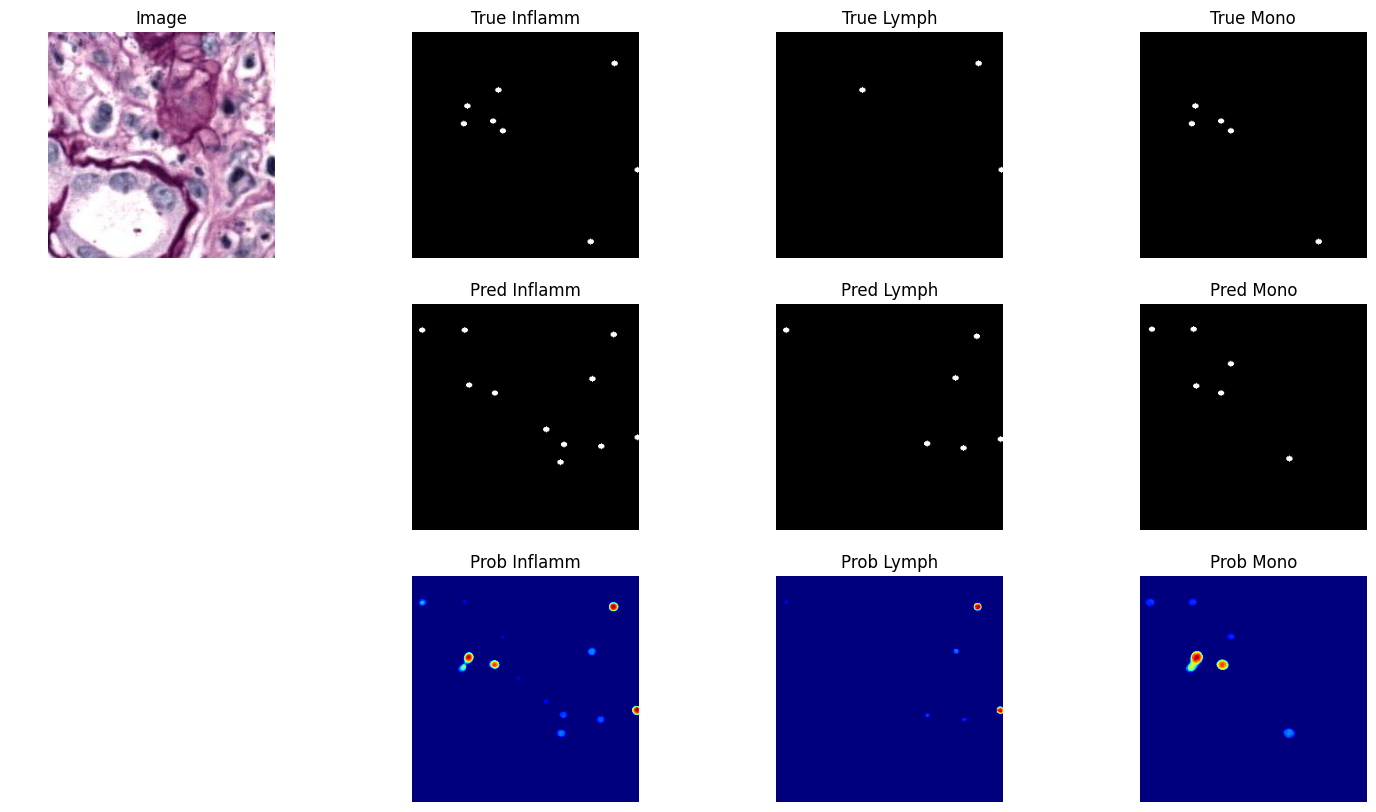

validation:   0%|          | 1/2911 [00:00<47:31,  1.02it/s]|2024-12-12|12:02:46.006| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


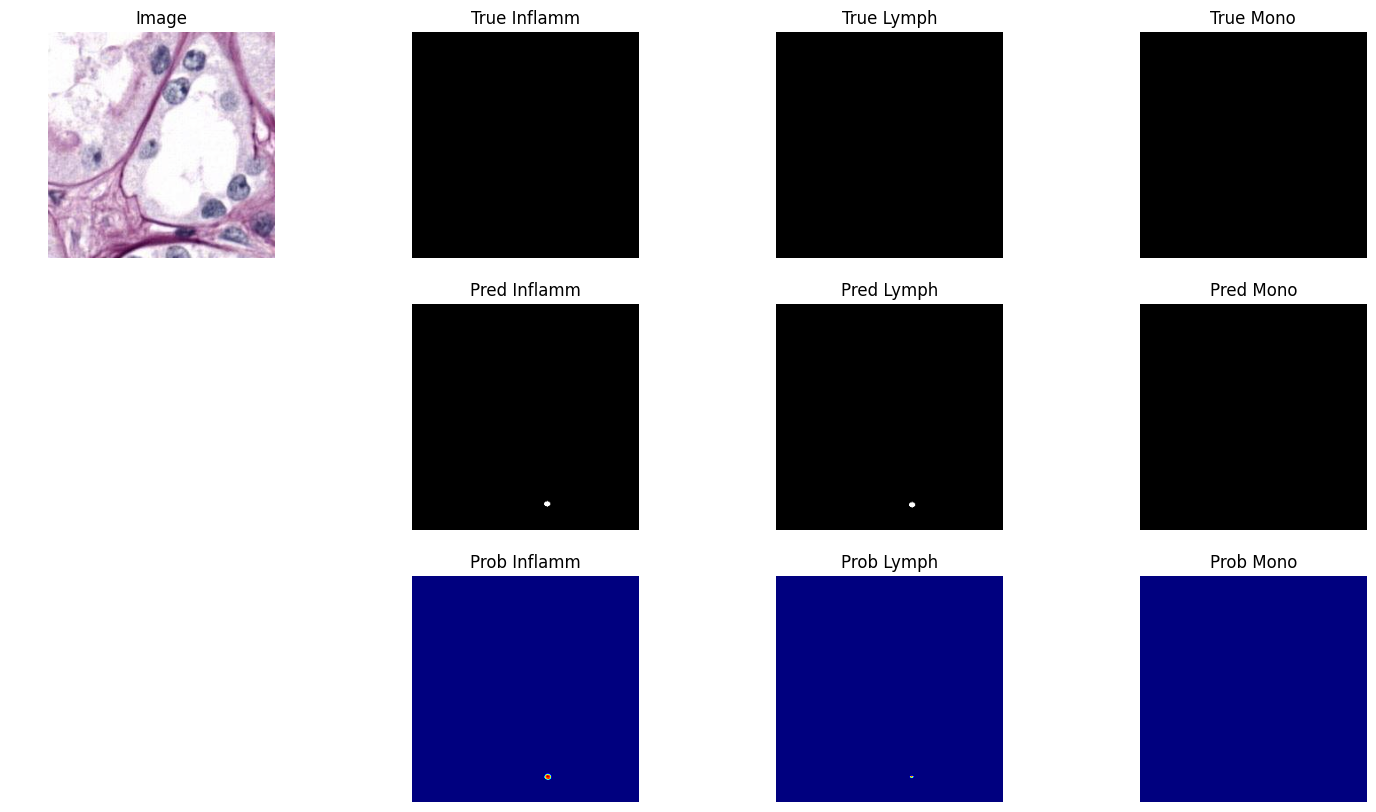

validation:   0%|          | 2/2911 [00:01<29:19,  1.65it/s]|2024-12-12|12:02:46.348| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


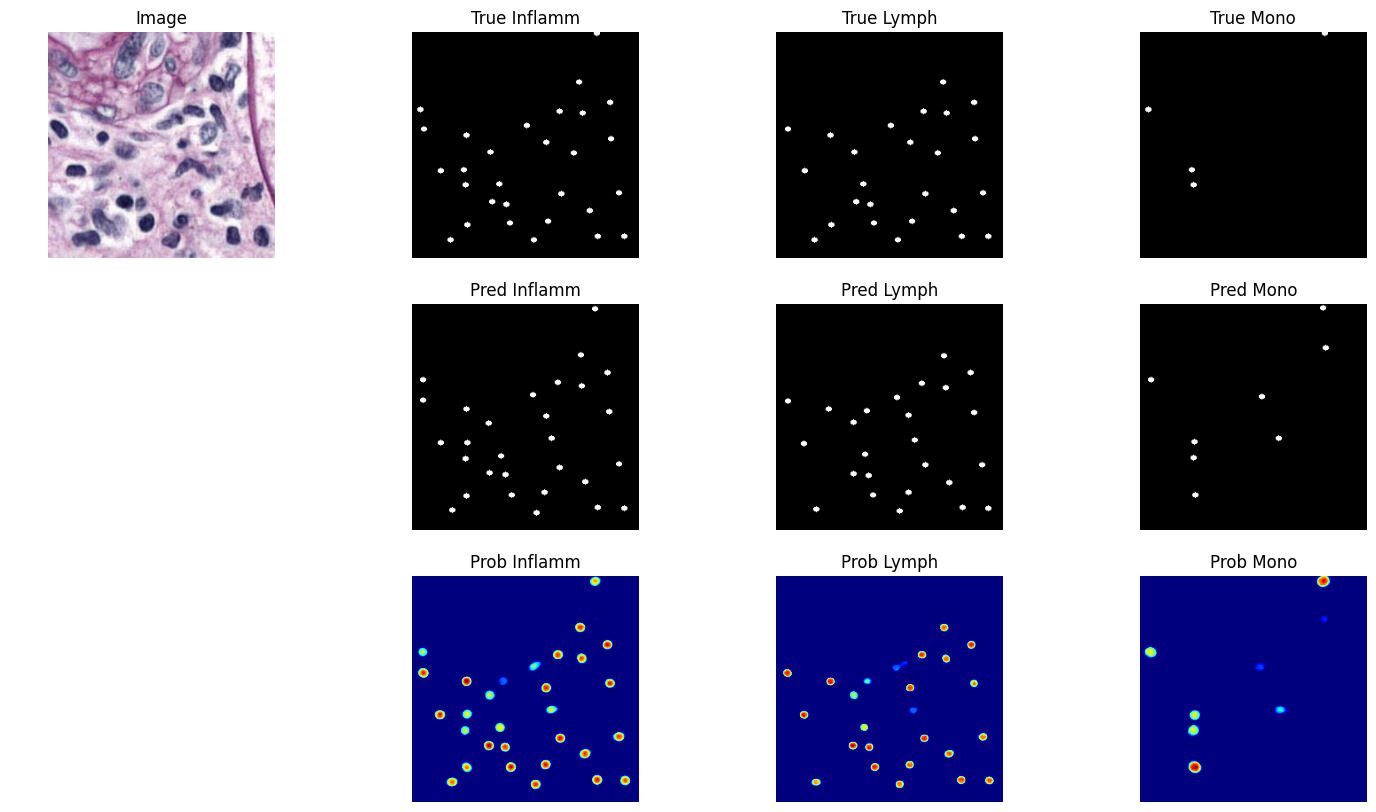

validation:   0%|          | 3/2911 [00:01<23:39,  2.05it/s]|2024-12-12|12:02:46.907| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


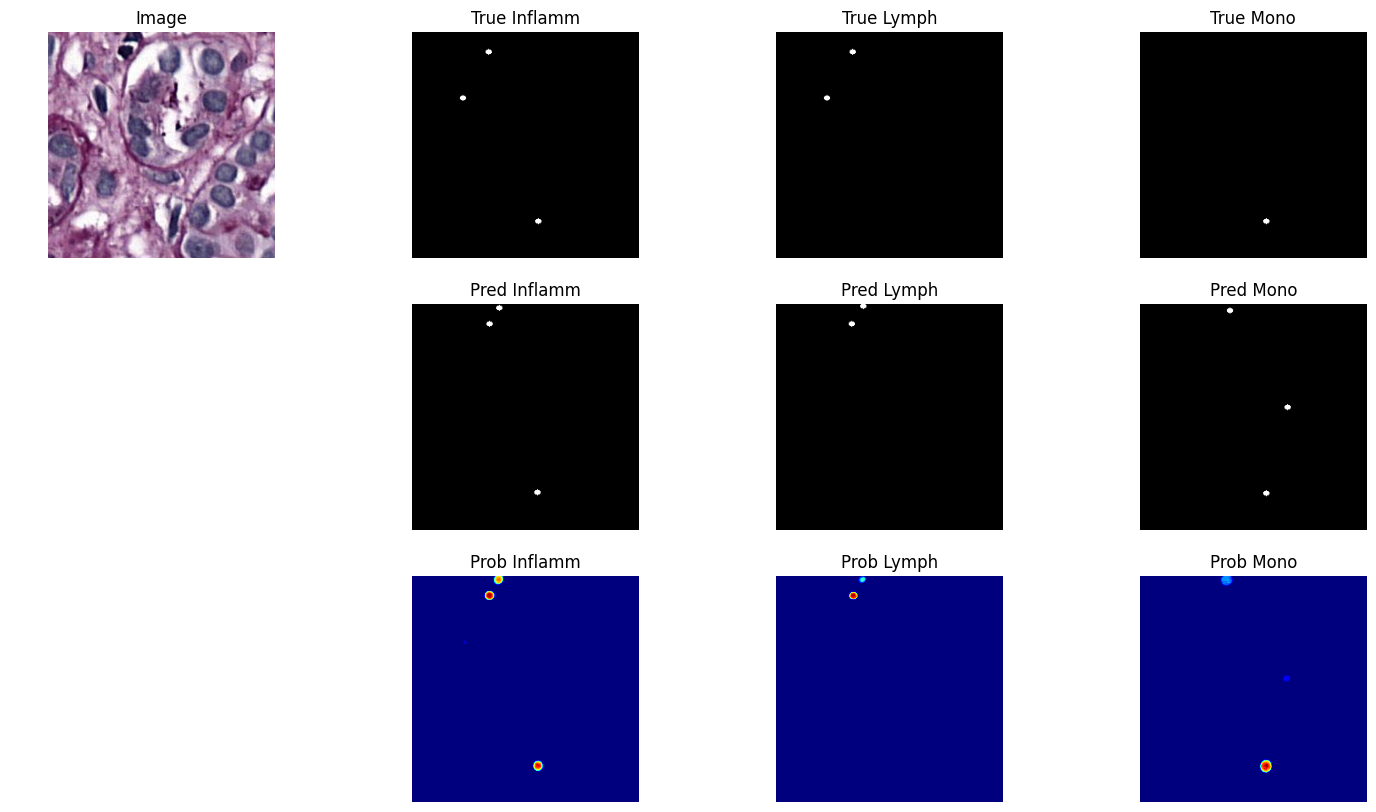

validation:   0%|          | 4/2911 [00:02<24:56,  1.94it/s]|2024-12-12|12:02:47.247| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


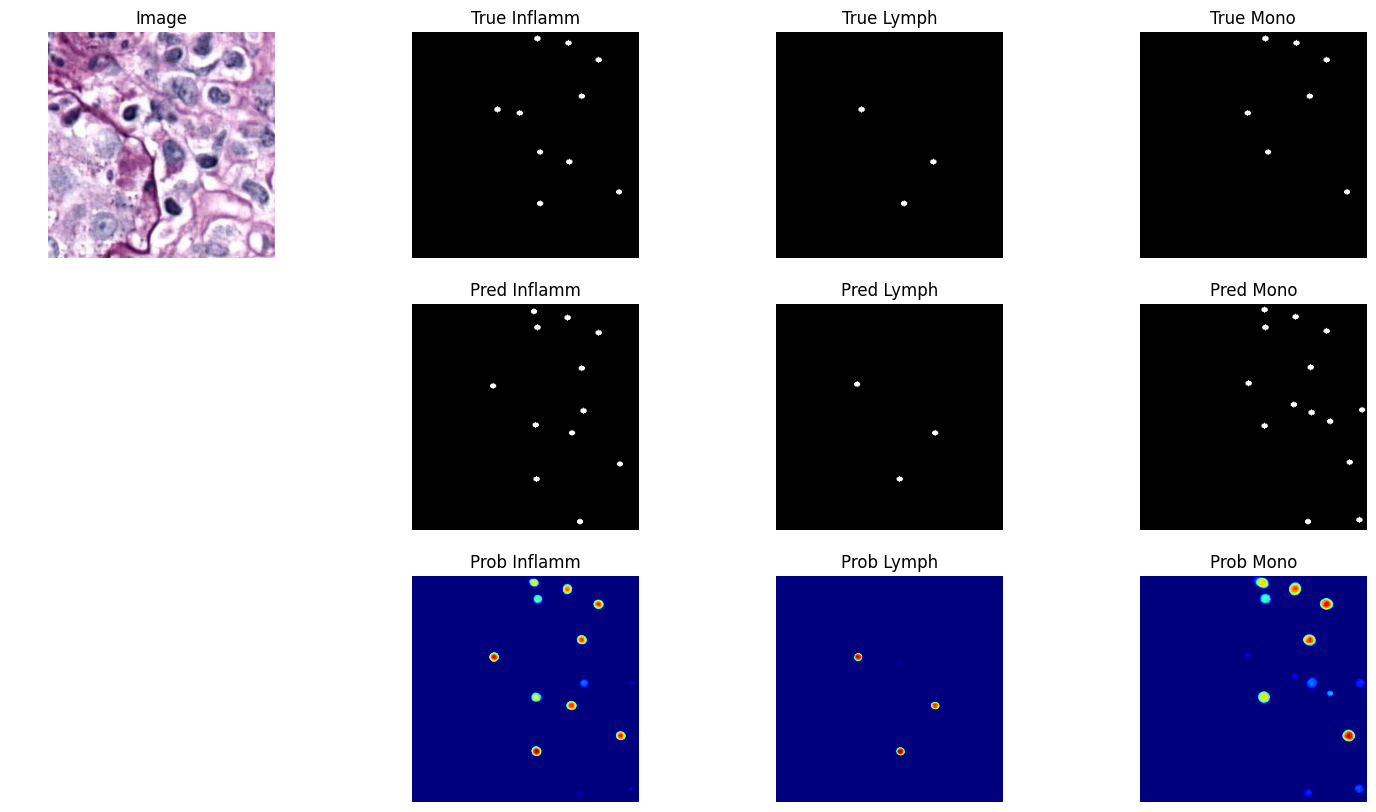

validation:   0%|          | 5/2911 [00:02<21:53,  2.21it/s]|2024-12-12|12:02:47.581| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


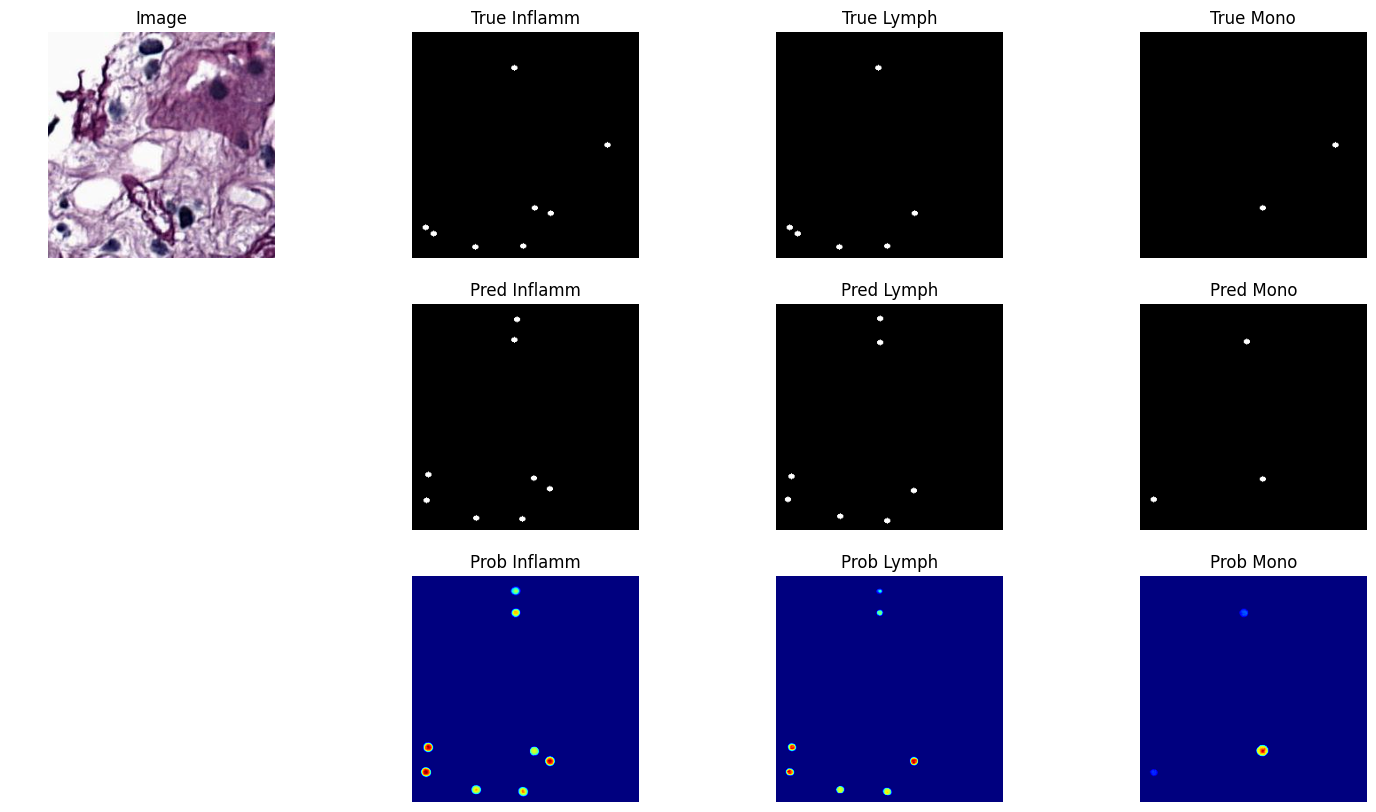

validation:   0%|          | 6/2911 [00:02<19:50,  2.44it/s]|2024-12-12|12:02:47.911| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


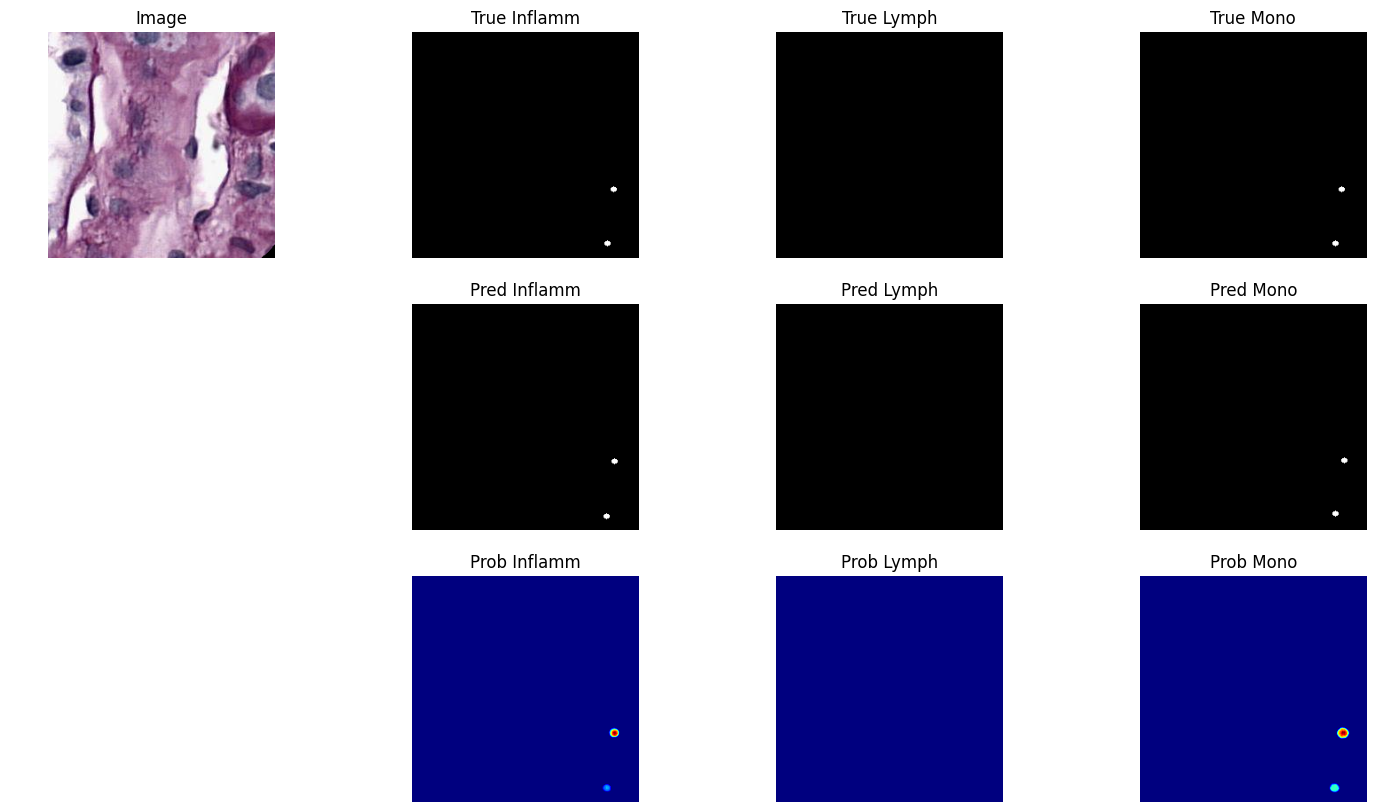

In [17]:
train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=1,
    do_augmentation=run_config["do_augmentation"],
    use_nuclick_masks=run_config["use_nuclick_masks"],
    disk_radius=7,
)

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):

    fig, axes = plt.subplots(3, 4, figsize=(18, 10))

    images = data["image"].cuda().float()
    inflamm_true_masks = data["binary_mask"][:, 0, :, :].numpy(
        force=True
    )
    lymph_true_masks = data["class_mask"][:, 0, :, :].numpy(
        force=True
    )
    mono_true_masks = data["class_mask"][:, 1, :, :].numpy(force=True)

    with torch.no_grad():
        inflamm_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        lymph_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        mono_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        for model in models:
            logits_pred = model(images)
            head_1_logits = logits_pred[:, 0:1, :, :]
            head_2_logits = logits_pred[:, 1:2, :, :]
            head_3_logits = logits_pred[:, 2:3, :, :]

            _inflamm_prob = activation_dict["head_1"](head_1_logits)
            _lymph_prob = activation_dict["head_2"](head_2_logits)
            _mono_prob = activation_dict["head_3"](head_3_logits)

            inflamm_prob += _inflamm_prob.detach().cpu()
            lymph_prob += _lymph_prob.detach().cpu()
            mono_prob += _mono_prob.detach().cpu()

        inflamm_prob /= len(models)
        lymph_prob /= len(models)
        mono_prob /= len(models)

    processed_output = hovernext_det_post_process(
        inflamm_prob,
        lymph_prob,
        mono_prob,
        thresholds=[0.5, 0.5, 0.5],
        min_distances=[11, 11, 11],
    )

    images = images.numpy(force=True)[0]
    images = np.moveaxis(images, 0, 2)
    images = imagenet_denormalise(images)

    axes[0][0].imshow(images)
    axes[0][0].set_title("Image")

    axes[0][1].imshow(inflamm_true_masks[0], cmap="gray")
    axes[0][1].set_title("True Inflamm")

    axes[2][1].imshow(inflamm_prob[0][0], cmap="jet")
    axes[2][1].set_title(f"Prob Inflamm")

    axes[0][2].imshow(lymph_true_masks[0], cmap="gray")
    axes[0][2].set_title("True Lymph")

    axes[0][3].imshow(mono_true_masks[0], cmap="gray")
    axes[0][3].set_title("True Mono")

    axes[2][3].imshow(mono_prob[0][0], cmap="jet")
    axes[2][3].set_title(f"Prob Mono")

    axes[1][2].imshow(
        dilate_mask(processed_output["lymph_mask"][0], 7), cmap="gray"
    )
    axes[1][2].set_title("Pred Lymph")

    axes[1][3].imshow(
        dilate_mask(processed_output["mono_mask"][0], 7), cmap="gray"
    )
    axes[1][3].set_title("Pred Mono")

    axes[1][1].imshow(
        dilate_mask(processed_output["inflamm_mask"][0], 7),
        cmap="gray",
    )
    axes[1][1].set_title("Pred Inflamm")

    axes[2][2].imshow(
        lymph_prob[0][0],
        cmap="jet",
    )
    axes[2][2].set_title(f"Prob Lymph")

    for ax in axes.ravel():
        ax.axis("off")
    plt.show()

    if i > 5:
        break